In [3]:
import pandas as pd
import datetime
import nltk
nltk.download('punkt')
import unicodedata
import matplotlib.pyplot as plt
import re
from numerize import numerize 

print('Reading file...')
df = pd.read_csv('../out_files/tell_all_FILLED.csv')
df = df[df['speech'].notna()]

print(df.tail(2))

[nltk_data] Downloading package punkt to /home/dina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from tqdm import tqdm
tqdm.pandas()

df = df.rename(columns={'parliamentary_period': 'period'})

df.period = df.period.apply(lambda x: x.replace(' review 9',''))
df.period = df.period.apply(lambda x: x.replace('period ',''))

df.period = df.period.astype(int)

print(datetime.datetime.now())

#Group speeches by period
PERperiod_df_original = df.groupby(df.period)['speech'].progress_apply(' '.join).reset_index()

print(datetime.datetime.now())

In [72]:
def periods_to_dates(periods):

    period_dict = {5:'7/1989-10/1989',
                  6:'11/1989-3/1990',
                  7:'4/1990-9/1993',
                  8:'10/1993-8/1996',
                  9:'10/1996-3/2000',
                  10:'4/2000-2/2004',
                  11:'3/2004-8/2007',
                  12:'9/2007-9/2009',
                  13:'10/2009-4/2012',
                  14:'5/2012-5/2012', 
                  15:'6/2012-12/2014', 
                  16:'2/2015-8/2015',
                  17:'10/2015-6/2019', 
                  18:'7/2019-7/2020'}
    
    if isinstance(periods, list):
        out = period_dict[periods[0]]+' &\n '+period_dict[periods[1]]
        return out 
    else:
        return 'Period '+str(periods)+'\n'+period_dict[periods]        

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [4]:
# Sort periods based on number in the string

periods = sorted(PERperiod_df_original.period.to_list())
period_pairs = step_one_pairs(periods)
print(period_pairs)

[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]


In [5]:
PERperiod_df_original['vocab'] = PERperiod_df_original.speech.progress_apply(lambda x: nltk.word_tokenize(x.lower()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [12:52<00:00, 55.21s/it]


Compute vocabulary/token intersection between pairs of periods

In [6]:
common_vocab = []

for pair in period_pairs:
    
    s1 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab.append([pair, common_voc])
    
common_vocab_df_original = pd.DataFrame(common_vocab, columns = ['pair', 'common_vocab'])
common_vocab_df_original.to_csv('../out_files/common_vocab_df_original.csv', index=False)
print(common_vocab_df_original.head(2))

     pair  common_vocab
0  (5, 6)         30043
1  (6, 7)         46959


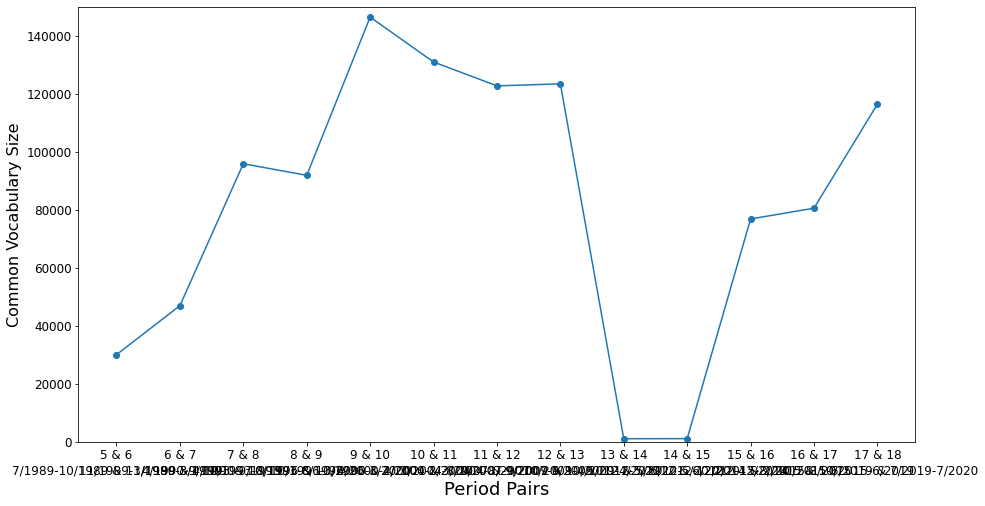

<Figure size 432x288 with 0 Axes>

In [8]:
from matplotlib.font_manager import FontProperties
import random
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

X = [i+0.5 for i in range(periods[0], periods[-1])]
Y = common_vocab_df_original.common_vocab.to_list()

plt.scatter(X,Y)
plt.plot(X,Y)

plt.xticks([i+0.5 for i in range(periods[0], periods[-1])], [
    (str(i)+' & '+str(i+1)+'\n'+periods_to_dates([i,i+1])) for i in range(periods[0], periods[-1])])

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,150000])
handles, labels = ax.get_legend_handles_labels()
# plt.savefig('../out_files/common_periodic_vocab_before.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)


### Load data after preprocessing

In [1]:
import pandas as pd
import datetime
import nltk
import unicodedata
import matplotlib.pyplot as plt
print('Reading file...')
df_cleaned = pd.read_csv('../out_files/tell_all_cleaned.csv')
df_cleaned = df_cleaned[df_cleaned['speech'].notna()]

print(df_cleaned.head(2))

Reading file...
                    member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
1  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  
0   προεδρευων  παρακαλειται @sw γραμματεας βουλγαρακης @sw 

In [10]:
test = df_cleaned.speech.iloc[0]
print(test)
print(nltk.word_tokenize(test))
print('------')
print(nltk.sent_tokenize(test))

παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος
['παρακαλειται', '@', 'sw', 'γραμματεας', 'βουλγαρακης', '@', 'sw', 'συνοδευσει', '@', 'sw', 'μακαριοτατο', 'αρχιεπισκοπο', 'αθηνων', '@', 'sw', 'πασης', 'ελλαδος', 'σεραφειμ', '@', 'sw', '@', 'sw', 'συνοδευοντα', '@', 'sw', 'μελη', '@', 'sw', 'ιερας', 'συνοδου', '@', 'sw', '@', 'sw', 'εισοδο', '@', 'sw', '@', 'sw', 'αιθουσα', '@', 'sw', 'βουλης', '@', 'sw', '@', 'sw', 'τελεσθει', 'αγιασμος', '.', '@', 'sw', 'συνεχεια', 'τελειται', '@', 'sw', 'καθιερωμενος', 'αγιασμος']
------
['παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.',

In [2]:
df_cleaned = df_cleaned.rename(columns={'parliamentary_period': 'period'})

df_cleaned.period = df_cleaned.period.apply(lambda x: x.replace(' review 9',''))
df_cleaned.period = df_cleaned.period.apply(lambda x: x.replace('period ',''))

df_cleaned.period = df_cleaned.period.astype(int)

print(datetime.datetime.now())
#Group speeches by year

PERperiod_df_cleaned = df_cleaned.groupby(df_cleaned.period)['speech'].progress_apply('. '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.

print(datetime.datetime.now())

In [12]:
periods_cleaned = sorted(PERperiod_df_cleaned.period.to_list())
period_pairs_cleaned = step_one_pairs(periods_cleaned)
print(period_pairs_cleaned)

[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]


In [13]:
PERperiod_df_cleaned['vocab'] = PERperiod_df_cleaned.speech.progress_apply(lambda x: nltk.word_tokenize(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [12:11<00:00, 52.27s/it]


In [14]:
common_vocab_cleaned = []

for pair in period_pairs_cleaned:
    
    s1 = set(PERperiod_df_cleaned.loc[(PERperiod_df_cleaned.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_cleaned.loc[(PERperiod_df_cleaned.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab_cleaned.append([pair, common_voc])
    
common_vocab_df_cleaned = pd.DataFrame(common_vocab_cleaned, columns = ['pair', 'common_vocab'])
common_vocab_df_cleaned.to_csv('../out_files/common_vocab_df_cleaned.csv', index=False)

print(common_vocab_df_cleaned.head(2))

     pair  common_vocab
0  (5, 6)         27439
1  (6, 7)         43915


[5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]


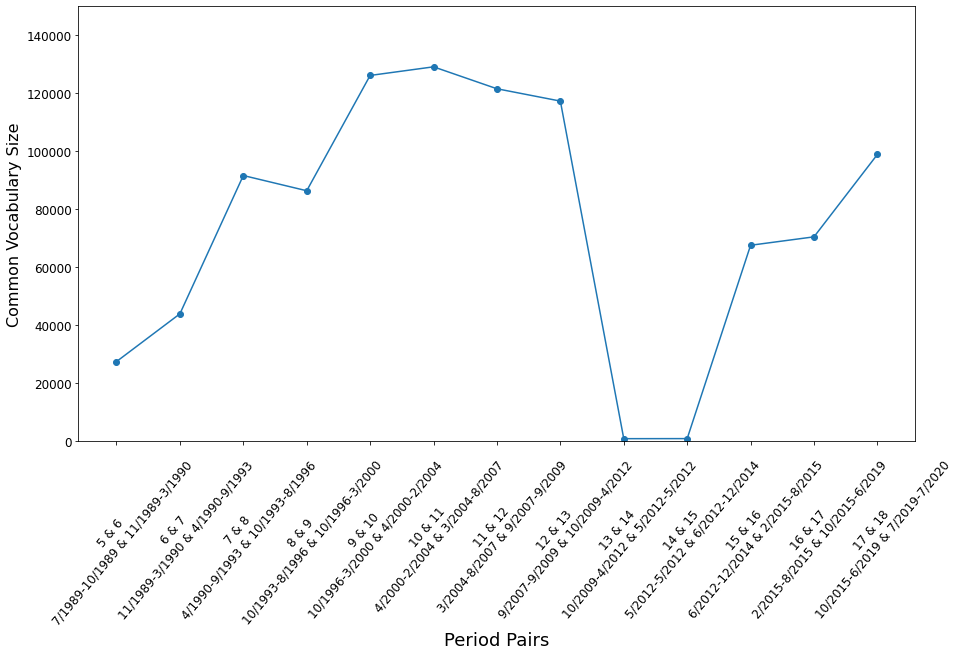

<Figure size 432x288 with 0 Axes>

In [15]:
fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

X = common_vocab_df_cleaned.pair.to_list()
Y = common_vocab_df_cleaned.common_vocab.to_list()
X = [i+0.5 for i in range(periods_cleaned[0], periods_cleaned[-1])]
print(X)
plt.scatter(X,Y)

plt.plot(X,Y)
plt.xticks([i+0.5 for i in range(periods_cleaned[0], periods_cleaned[-1])], [
    (str(i)+' & '+str(i+1)+'\n'+periods_to_dates([i,i+1])) for i in range(periods_cleaned[0], periods_cleaned[-1])],
          rotation=50)

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,150000])

handles, labels = ax.get_legend_handles_labels()
# plt.savefig('../out_files/common_periodic_vocab_after.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)


### After merging periods

In [6]:
df_merged_cleaned = df_cleaned.copy()

In [7]:
df_merged_cleaned.loc[(df_merged_cleaned.period==5), 'period'] = 7
df_merged_cleaned.loc[(df_merged_cleaned.period==6), 'period'] = 7
df_merged_cleaned.loc[(df_merged_cleaned.period==14), 'period'] = 15
df_merged_cleaned.loc[(df_merged_cleaned.period==16), 'period'] = 17


In [8]:
PERperiod_df_merged_cleaned = df_merged_cleaned.groupby(df_merged_cleaned.period)['speech'].progress_apply('. '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 21.74it/s]


In [9]:
periods_merged_cleaned = sorted(PERperiod_df_merged_cleaned.period.to_list())
print(periods_merged_cleaned)

period_pairs_merged_cleaned = step_one_pairs(periods_merged_cleaned)
print(period_pairs_merged_cleaned)

[7, 8, 9, 10, 11, 12, 13, 15, 17, 18]
[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]


In [10]:
PERperiod_df_merged_cleaned['vocab'] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: nltk.word_tokenize(x))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:47<00:00, 70.72s/it]


In [11]:
common_vocab_merged_cleaned = []

for pair in period_pairs_merged_cleaned:
    print(pair)
    
    s1 = set(PERperiod_df_merged_cleaned.loc[(PERperiod_df_merged_cleaned.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_merged_cleaned.loc[(PERperiod_df_merged_cleaned.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab_merged_cleaned.append([pair, common_voc])
    
common_vocab_df_merged_cleaned = pd.DataFrame(common_vocab_merged_cleaned, columns = ['pair', 'common_vocab'])
common_vocab_df_merged_cleaned.to_csv('../out_files/common_vocab_df_merged_cleaned.csv', index=False)

print(common_vocab_df_merged_cleaned.head(2))

(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 15)
(15, 17)
(17, 18)
     pair  common_vocab
0  (7, 8)         93171
1  (8, 9)         86361


[7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 14.0, 16.0, 17.5]
[93171, 86361, 126131, 129103, 121537, 117287, 120224, 127269, 100949]


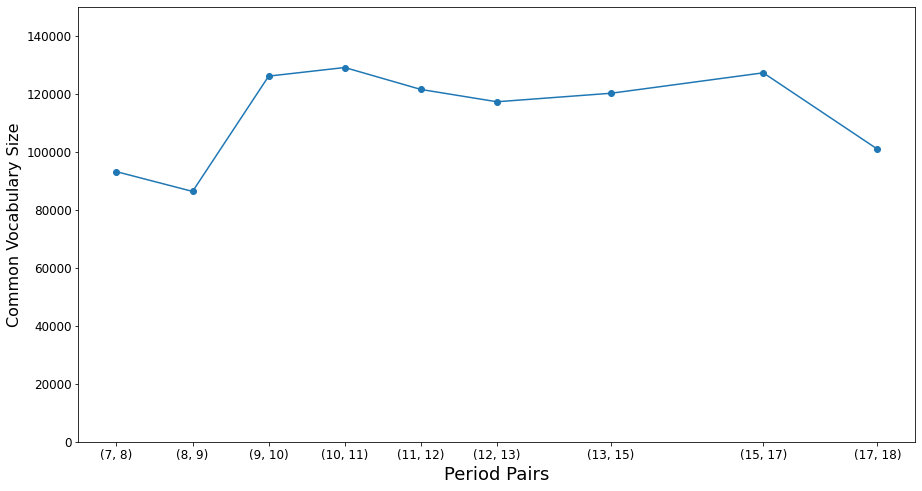

<Figure size 432x288 with 0 Axes>

In [12]:
import seaborn as sns

fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

# X = common_vocab_df_merged_cleaned.pair.to_list()
Y = common_vocab_df_merged_cleaned.common_vocab.to_list()
X = [(pair[0]+pair[1])/2 for pair in period_pairs_merged_cleaned]

print(X)
print(Y)
plt.scatter(X,Y)

plt.plot(X,Y)
plt.xticks(X, period_pairs_merged_cleaned)

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)
# plt.gca().set_ylim(bottom=0)
# plt.gca().set_ylim([0,150000])
# plt.gca().set_ylim(bottom=0)150000
ax = plt.gca()
ax.set_ylim([0,150000])
handles, labels = ax.get_legend_handles_labels()
# plt.savefig('../out_files/common_periodic_vocab_merged_after.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)


In [6]:
common_vocab_df_original = pd.read_csv('../out_files/common_vocab_df_original.csv')
common_vocab_df_original['version'] = 'without preprocessing'

common_vocab_df_cleaned = pd.read_csv('../out_files/common_vocab_df_cleaned.csv')
common_vocab_df_cleaned['version'] = 'with preprocessing'

common_vocab_df_merged_cleaned = pd.read_csv('../out_files/common_vocab_df_merged_cleaned.csv')
common_vocab_df_merged_cleaned['version'] = 'with preprocessing and merging'


In [7]:
all_versions_df = common_vocab_df_original.append(common_vocab_df_cleaned).append(common_vocab_df_merged_cleaned)

In [8]:
# all_versions_df.to_csv('../out_files/all_versions_common_vocab.csv', index=False)

In [9]:
all_versions_df

,pair,common_vocab,version
0,"(5, 6)",30043,without preprocessing
1,"(6, 7)",46959,without preprocessing
2,"(7, 8)",95910,without preprocessing
3,"(8, 9)",91904,without preprocessing
4,"(9, 10)",146489,without preprocessing
5,"(10, 11)",131007,without preprocessing
6,"(11, 12)",122770,without preprocessing
7,"(12, 13)",123471,without preprocessing
8,"(13, 14)",1063,without preprocessing
9,"(14, 15)",1089,without preprocessing


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


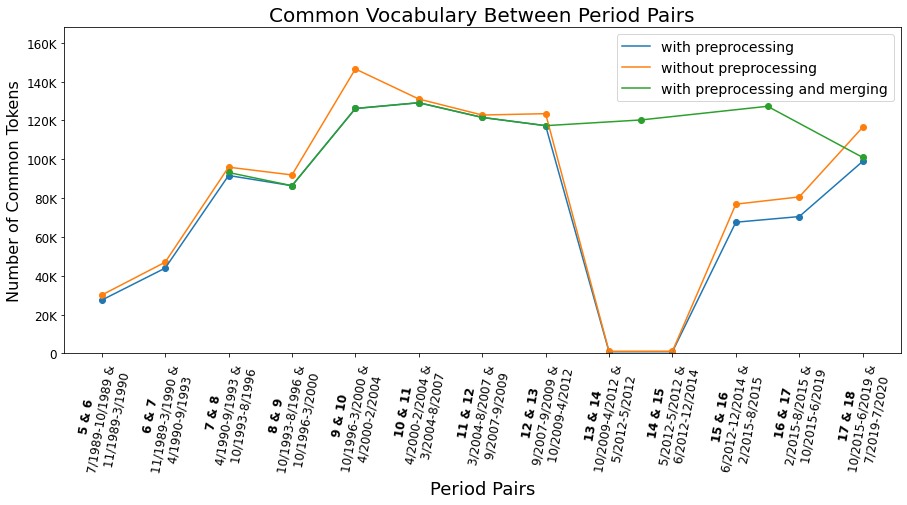

<Figure size 432x288 with 0 Axes>

In [27]:
import seaborn as sns
import ast
from matplotlib.ticker import FuncFormatter


fig = plt.figure(figsize=(15, 6))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

versions = list(set(all_versions_df.version.to_list()))
                
for version in versions:
    
    Y = all_versions_df.loc[(all_versions_df['version']==version)].common_vocab.to_list()
    X_1 = [ast.literal_eval(x) for x in all_versions_df.loc[(all_versions_df['version']==version)].pair.to_list()]
    X = [(pair[0]+pair[1])/2 for pair in X_1]

#     print(Y)
#     print(X)
    plt.scatter(X,Y)

    plt.plot(X,Y)
#     plt.xticks(X, Y)

periods = [i for i in range(5,19)]
print(periods)
plt.xticks([i+0.5 for i in range(periods[0], periods[-1])], [
    (r"$\bf{"+str(i)+"\ &\ "+str(i+1)+"}$"+"\n"+periods_to_dates([i,i+1])) for i in range(periods[0], periods[-1])],
          rotation=80)

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Number of Common Tokens', fontsize=16)
# plt.gca().set_ylim(bottom=0)
# plt.gca().set_ylim([0,150000])
# plt.gca().set_ylim(bottom=0)150000

ax = plt.gca()
ax.set_ylim([0,168000])
handles, labels = ax.get_legend_handles_labels()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
plt.title('Common Vocabulary Between Period Pairs', fontsize=20)
plt.legend(versions, loc='upper right',prop={'size': 14})

plt.savefig('../out_files/common_vocab.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)
